# Проект - Подсчет количества людей в магазине

Дисциплина: "Проектирование нейроных сетей для задач анализа изображений" (ИТМО, 2025)

Выполнили:
- Трефилов Яков
- Диль Диана
- Киселева Анастасия
- Ракич Тина
- Душкина Надежда
- Давыдова Ульяна

**Цель проекта:** обучить модель компьютерного зрения для решения задачи подсчета количества людей в магазине

## Описание данных

**Ссылка на датсет:** https://www.kaggle.com/datasets/angelosgiotis/consumers-bid

Предложенный датасет для работы состоить из двух частей:
- Набор данных **"Consumers"** включает изображения розничных потребителей, снятые с помощью RGB-камер, и их реальные координаты в виде bound box.
- Набор данных **"BID"** состоит из обрезанных изображений полного тела потребителей с аннотациями, а также реальной информацией об их возрасте и поле.

В данной работе использован только набор данных **"Consumers"**, тк. ее целью является только под щхет количества людей в магазине.

Следовательно, в рботе будет обучена модель детекции, а иоговое количество людей в магазине будем определять подсчетом объектов, которые модель успела детектировать.

## Загрузка данных

Струдктура используемого набора данных представлена на картике:

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F17922636%2F064ee2e51239f2c5b0a5e38685689be4%2FConsumersSmall.png?generation=1701373217319160&alt=media)

где *gt.txt* содержит полную информацию об аннотациях `[frame_id, consumer_id, bounding-box]` для всей последовательности, для использования в алгоритме детекции.

Каждый файл frameID.txt содержит информацию об аннотациях `[consumer_ID, bounding_box_coords ((x, y, width, height)), age_group ,gender]` для каждого аннотированного экземпляра в кадре. Данная инфромация в нашей работе использоваться не будет.


In [1]:
# установка и загрузка библиотек
!pip install kagglehub

In [2]:
!pip install torch torchvision albumentations

In [3]:
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw
import numpy as np
import csv

import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, ToTensor

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Subset
import random

import kagglehub

In [29]:
# загрузка датасета с Kaggle
path = kagglehub.dataset_download("angelosgiotis/consumers-bid")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'consumers-bid' dataset.
Path to dataset files: /kaggle/input/consumers-bid


In [30]:
class ConsumersGTDataset(Dataset):
    """
    Набор данных Consumers. Каждая папка содержит изображения и файл `gt/gt.txt`.
        Структура:
          root/
            Sequence_ID000/
              img_00001.jpg
              img_00002.jpg
              gt/
                gt.txt
            Sequence_ID001/
              ...
    Формат gt.txt (без заголовка), каждая строка:
    photo_id, consumer_id, x_top_left, y_top_left, width, height
    Координаты предполагаются как левый верхний угол (x, y, width, height).
    photo_id может включать расширение или быть просто идентификатором кадра.
    """

    def __init__(self, root, sequences=None, transform=None,
                 img_extensions=('.jpg', '.jpeg', '.png'), try_find=True):
        self.root = Path(root)
        if not self.root.exists():
            raise FileNotFoundError(f"Root path does not exist: {self.root}")
        self.transform = transform
        self.img_extensions = tuple(e.lower() for e in img_extensions)
        self.try_find = try_find

        # список sequences для загрузки
        if sequences is None:
            sequences = sorted([p.name for p in self.root.iterdir() if p.is_dir()])
        self.sequences = sequences

        # mapping image_path -> список аннотаций
        self._anns = {}  # Path -> список (consumer_id, cx, cy, w, h, normalized_flag_guess)
        for seq in self.sequences:
            seq_dir = self.root / seq
            if not seq_dir.exists() or not seq_dir.is_dir():
                continue
            gt_path = seq_dir / 'gt' / 'gt.txt'
            if not gt_path.exists():
                # sequences без файла gt не рассматрывем
                continue
            # парсим gt file
            with open(gt_path, 'r', encoding='utf-8') as f:
                first = f.readline()
                if ',' in first:
                    delimiter = ','
                else:
                    delimiter = None
            with open(gt_path, 'r', encoding='utf-8') as f:
                if delimiter:
                    reader = csv.reader(f, delimiter=delimiter)
                else:
                    reader = csv.reader(f, delimiter=None, skipinitialspace=True)
                for row in reader:
                    if not row:
                        continue
                    row = [r.strip() for r in row if r is not None and str(r).strip() != '']
                    if len(row) < 6:
                        continue
                    photo_id_raw = row[0]
                    try:
                        consumer_id = int(row[1])
                        x_tl = float(row[2])
                        y_tl = float(row[3])
                        w_box = float(row[4])
                        h_box = float(row[5])
                    except Exception:
                        continue


                    img_path = self._resolve_image_path(seq_dir, photo_id_raw)
                    if img_path is None:
                        if self.try_find:
                            img_path = self._fuzzy_find(seq_dir, photo_id_raw)
                    if img_path is None:
                        continue


                    normalized_guess = (0.0 <= x_tl <= 1.0 and 0.0 <= y_tl <= 1.0 and 0.0 <= w_box <= 1.0 and 0.0 <= h_box <= 1.0)

                    key = str(img_path.resolve())
                    self._anns.setdefault(key, []).append((consumer_id, x_tl, y_tl, w_box, h_box, normalized_guess))

        # Создаем элементы: включаем все файлы изображений в sequence-ах
        # даже если у них нет аннотаций (для них мы вернем пустые target-ы)
        items = []
        for seq in self.sequences:
            seq_dir = self.root / seq
            if not seq_dir.exists() or not seq_dir.is_dir():
                continue
            for p in sorted(seq_dir.iterdir()):
                if p.is_file() and p.suffix.lower() in self.img_extensions:
                    items.append(p)
        self.items = [p.resolve() if isinstance(p, Path) else Path(p).resolve() for p in items]

    def _resolve_image_path(self, seq_dir: Path, photo_id_raw: str):

        pid = photo_id_raw
        p = seq_dir / pid
        if p.exists() and p.is_file():
            return p

        p = seq_dir / pid
        if p.exists() and p.is_file():
            return p

        if not Path(pid).suffix:
            for ext in self.img_extensions:
                candidate = seq_dir / (pid + ext)
                if candidate.exists():
                    return candidate

        name = Path(pid).name
        p = seq_dir / name
        if p.exists():
            return p
        return None

    def _fuzzy_find(self, seq_dir: Path, photo_id_raw: str):
        pid = photo_id_raw.lower()
        for p in seq_dir.rglob('*'):
            if p.is_file() and p.suffix.lower() in self.img_extensions:
                if pid in p.name.lower():
                    return p
        return None

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path = self.items[idx]
        ann_list = self._anns.get(str(img_path.resolve()), [])
        img = Image.open(img_path).convert('RGB')
        w_img, h_img = img.size

        boxes = []
        ids = []
        for (cid, x_tl, y_tl, w_box, h_box, normalized_guess) in ann_list:
            if normalized_guess:
                # нормализованные координаты, преобразуем в пиксели
                x_px = x_tl * w_img
                y_px = y_tl * h_img
                w_px = w_box * w_img
                h_px = h_box * h_img
            else:
                x_px, y_px, w_px, h_px = x_tl, y_tl, w_box, h_box

            # (x_px,y_px,w_px,h_px) -> x1,y1,x2,y2
            x1 = x_px
            y1 = y_px
            x2 = x_px + w_px
            y2 = y_px + h_px

            x1 = max(0.0, x1)
            y1 = max(0.0, y1)
            x2 = min(float(w_img), x2)
            y2 = min(float(h_img), y2)

            if x2 <= x1 or y2 <= y1:
                continue

            boxes.append([x1, y1, x2, y2])
            ids.append(int(cid))

        if boxes:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            ids = torch.tensor(ids, dtype=torch.long)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            ids = torch.tensor([], dtype=torch.long)

        target = {
            'boxes': boxes,
            'ids': ids,
            'image_id': torch.tensor([idx]),
            'file_path': str(img_path)
        }

        if self.transform is not None:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        return img, target

Show image No.150 with 1 bound boxes


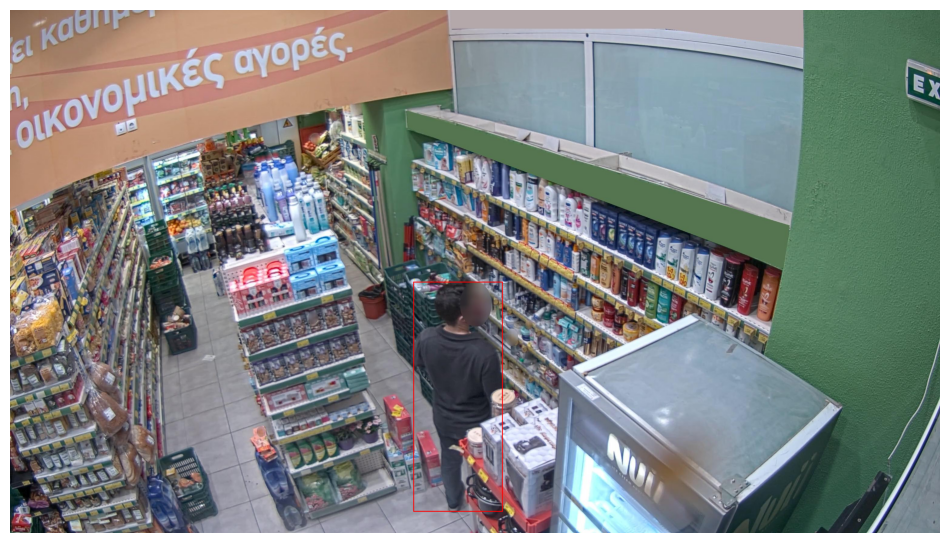

In [35]:
# Теперь создам датасет и визуализуализируем изображение с bound box для произвольного индекса

dataset_root = Path(path) / 'Consumers' if 'path' in globals() else Path('path/to/dataset_root')
dataset = ConsumersGTDataset(root=dataset_root, transform=None)

def visualize_idx(dataset, idx, figsize=(12,8), show=True):
    img_tensor, target = dataset[idx]
    fp = target.get('file_path', None)

    if fp is not None and Path(fp).exists():
      pil_img = Image.open(fp).convert('RGB')
    else:
      pil_img = ToPILImage()(img_tensor)

    draw = ImageDraw.Draw(pil_img)
    boxes = target.get('boxes')
    ids = target.get('ids')
    if boxes is not None and boxes.numel() > 0:
        boxes_np = boxes.detach().cpu().numpy()
        ids_np = ids.detach().cpu().numpy() if ids is not None and ids.numel() > 0 else [None]*len(boxes_np)
        for b, cid in zip(boxes_np, ids_np):
            x1,y1,x2,y2 = b
            draw.rectangle([x1, y1, x2, y2], outline='red', width=3)
            label = str(int(cid)) if cid is not None else ''

            text_pos = (max(0, x1), max(0, y1-12))
            draw.text(text_pos, label, fill='yellow')
    if show:
        plt.figure(figsize=figsize)
        plt.imshow(pil_img)
        plt.axis('off')
    return pil_img, target

# Визуализируем первый элемент
if len(dataset) == 0:
  print('Dataset пустой — необходимо изменить путь `dataset_root` или проверить наличие gt/gt.txt в sequence папках')
else:
  idx = 150
  pil_img, target = visualize_idx(dataset, idx)
  print(f'Show image No.{idx} with', target.get('boxes').shape[0], 'bound boxes')

### Преобразование данных (аугментации)

In [36]:
# Определим аугментации, которые будем использовать на данных

train_alb = A.Compose([
    A.HorizontalFlip(p=0.5),
    #A.Resize(480, 854)
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5, border_mode=0),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.0))

val_alb = A.Compose([
    #A.Resize(480, 854)
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.0))

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


### Разделение набора данных на train и валидацию

In [37]:
# Разбиение индексов на train и валидацию
def split_indices(dataset, val_ratio=0.2, seed=42):
    n = len(dataset)
    idx = list(range(n))
    rnd = random.Random(seed)
    rnd.shuffle(idx)
    split = int(n*(1-val_ratio))
    return idx[:split], idx[split:]

# Соѕдаем датасет
base_ds = ConsumersGTDataset(root=dataset_root, transform=None)
# Вздельяем индексы изображений для train и validation датасетов
train_idx, val_idx = split_indices(base_ds, val_ratio=0.2, seed=42)
train_base = Subset(base_ds, train_idx)
val_base = Subset(base_ds, val_idx)

print('Sizes — all:', len(base_ds), 'train:', len(train_base), 'val:', len(val_base))

Sizes — all: 1466 train: 1172 val: 294


#### Резюме для дальнейшей работы:

- Создан класс `ConsumersGTDataset` для загрузки изображений и bbox.
- Для аугментаций есть трансформации `train_alb` и `val_alb`.
- Функция `visualize_idx(dataset, idx)` показывает изображение с нарисованными bounding-box и id.



## Подготовка данных для Faster R-CNN

В дальнейшей части проекта мы планируем использовать детектор
объектов Faster R-CNN для задачи подсчета людей в магазине.

Эта модель ожидает, что датасет для каждого изображения будет
возвращать:

```
   img: Tensor[C, H, W]
   target: словарь с ключами
       "boxes"  -> Tensor[N, 4]  (x1, y1, x2, y2)
       "labels" -> Tensor[N]     (int64, класс каждого бокса)
       (опционально: "image_id", "area", "iscrowd", ...)

```

Наш ConsumersGTDataset уже умеет читать изображения и боксы людей,
но сейчас он возвращает словарь вида:
```
{
       "boxes": Tensor[N, 4],
       "ids":   Tensor[N],      # идентификатор consumer_id, а не класс
       "image_id": ...,
       "file_path": ...
}
```



Для обучения Faster R-CNN нам нужно привести таргеты к формату
 {"boxes", "labels"} и ввести разметку классов. В текущей задаче
 у нас один тип объекта — "person", поэтому всем боксам
 ставим один и тот же класс: label = 1.

 Ниже определяем обертку DetectionConsumersDataset, которая
 адаптирует ConsumersGTDataset к формату, ожидаемому Faster R-CNN,
 и собираем новые DataLoader-ы для обучения детектора.


In [38]:
# класс для использования непосредственно при обучении
class DetectionConsumersDataset(Dataset):
    def __init__(self, base_ds, transforms=None):
        """
        Ожидаем, что base_ds возвращает:
            img: PIL image or numpy array (H, W, C)
            target: dict with key 'boxes' in pascal_voc format
        """
        self.base_ds = base_ds
        self.transforms = transforms

    def __getitem__(self, idx):
        img, target = self.base_ds[idx]

        boxes = target["boxes"]

        # Только один класс: person -> label = 1
        if boxes.shape[0] > 0:
            labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        else:
            labels = torch.zeros((0,), dtype=torch.int64)

        if torch.is_tensor(img):
            img = img.permute(1, 2, 0).cpu().numpy()

        boxes_np = boxes.cpu().numpy()
        labels_np = labels.cpu().numpy()

        if self.transforms is not None:
            augmented = self.transforms(
                image=img,
                bboxes=boxes_np,
                labels=labels_np
            )

            img = augmented["image"]           # Tensor [C,H,W] (в аугментациях используем ToTensorV2)
            boxes = torch.as_tensor(
                augmented["bboxes"], dtype=torch.float32
            )
            labels = torch.as_tensor(
                augmented["labels"], dtype=torch.int64
            )
        else:
            # Формируем тензор, если преобразования не переданы
            img = torch.as_tensor(img).permute(2, 0, 1)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
        }

        return img, target

    def __len__(self):
        return len(self.base_ds)

In [39]:
# Для использования в collate_fn в dataloader-ах
def detection_collate_fn(batch):
    """
    batch: список [(img, target), (img, target), ...]
    Возвращает:
        images:  список тензоров
        targets: список словарей
    """
    return tuple(zip(*batch))


In [40]:
# Обертки поверх train_base и val_base
train_det_ds = DetectionConsumersDataset(train_base, transforms = train_alb)
val_det_ds   = DetectionConsumersDataset(val_base, transforms = val_alb)

# DataLoader-ы для обучения Faster R-CNN

train_det_loader = DataLoader(
    train_det_ds,
    batch_size=4, # небольшой размер батча, чтобы при обучении модель не падала из-за нехватки RAM
    shuffle=True,
    collate_fn=detection_collate_fn,
    pin_memory = True,
    num_workers = 2, # если запускать на windows обязательно указать num_workers = 0
    persistent_workers=False
)

val_det_loader = DataLoader(
    val_det_ds,
    batch_size=4,
    shuffle=False,
    collate_fn=detection_collate_fn,
    pin_memory = True,
    num_workers = 2, # если запускать на windows обязательно указать num_workers = 0
    persistent_workers=False
)

print("Detection train size:", len(train_det_ds))
print("Detection val size:  ", len(val_det_ds))


Detection train size: 1172
Detection val size:   294


In [41]:
# Проверка для одного батча
images_batch, targets_batch = next(iter(train_det_loader))

print("Batch size:", len(images_batch))
print("Image shape:", images_batch[0].shape)
print("Keys in target:", targets_batch[0].keys())
print("Boxes shape:", targets_batch[0]["boxes"].shape)
print("Labels:", targets_batch[0]["labels"])


Batch size: 4
Image shape: torch.Size([3, 1728, 3072])
Keys in target: dict_keys(['boxes', 'labels', 'image_id'])
Boxes shape: torch.Size([1, 4])
Labels: tensor([1])


## Создание Faster R-CNN и обучение модели

In [42]:
# загрузка дополнительных библиотек
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

#model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
#num_classes = 2
#in_features = model.roi_heads.box_predictor.cls_score.in_features
#model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
#model = model.to(device)
#print(model)

Device: cuda


Модель Faster R-CNN с бэкбоном ResNet-50-FPN довольно тяжелая, с большим количетсвом параметров. Количество изображений используемых в работе и наши вычислительные мощности довольно ограниченные, из-за чего было принято решение использовать более простую модель с бэкбоном ResNet18, архитектура которой нами изучалась на занятиях и вручную реализовалась в втором домашнем задании.

In [43]:
# Загрузка более легкой модели
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# ResNet18 Backbone
# загрузка с предобученными весами
backbone = torchvision.models.resnet18(weights="DEFAULT")
backbone = torch.nn.Sequential(*list(backbone.children())[:-2]) # извлекаем только сверточную часть для извлечения признаков
backbone.out_channels = 512 # кол-во выходным признаков

# Создаем якоры (Anchor generator)  для предсказания bound box
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

num_classes = 2 # 1 класс (покупатель) + фон изображения
# Faster R-CNN модель
model = FasterRCNN(
    backbone,
    num_classes=num_classes,
    rpn_anchor_generator=anchor_generator,
)


In [44]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # адаптируем модель под нашу конкретную задачу
model = model.to(device)

# Архитектура модели
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
       

In [45]:
# Проверка на 1 батче

images_batch, targets_batch = next(iter(train_det_loader))

images_batch = [img.to(device) for img in images_batch]
targets_batch = [{k: v.to(device) for k, v in t.items()} for t in targets_batch]

model.train()
loss_dict = model(images_batch, targets_batch)
losses = sum(loss for loss in loss_dict.values())

print("Loss dict:", {k: float(v) for k, v in loss_dict.items()})
print("Total loss:", float(losses))


Loss dict: {'loss_classifier': 0.6618949174880981, 'loss_box_reg': 0.007019417360424995, 'loss_objectness': 0.7148008346557617, 'loss_rpn_box_reg': 0.001778863137587905}
Total loss: 1.3854939937591553


### Обучение модели

In [16]:
# загрузка дополнительных библиотек
from tqdm import tqdm
import copy

In [17]:
! pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.7 MB/s eta 0:00:00


In [18]:
# метрики для оценки качества модели mAP, IoU
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchmetrics.detection.iou import IntersectionOverUnion

In [19]:
def train_detection_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    lr_scheduler,
    device,
    num_epochs=20,
    save_path="best_model.pth"
):
    """
    Функция для обучения модели детекции. Возвращает словарь со следующми значениями метрик:
      - Train loss
      - Train mean IoU
      - Validation mean IoU
      - Train mAP
      - Validation mAP

    Сохранаяет checkpoint модели в зависимости от значения mAP на валиадации на текущей эпохе.
    """

    history = {
        "train_loss": [],
        "train_mIoU": [],
        "val_mIoU": [],
        "train_mAP": [],
        "val_mAP": [],
    }

    best_mAP = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    model.to(device)

    for epoch in range(num_epochs):

        # Обучение
        model.train()
        running_loss = 0.0

        train_iou_metric = IntersectionOverUnion().to(device)
        train_map_metric = MeanAveragePrecision().to(device)

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", unit="batch")
        for images, targets in pbar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()

            running_loss += losses.item()

            # Вычисление метрик
            model.eval()
            with torch.no_grad():
                outputs = model(images)

                train_iou_metric.update(outputs, targets)
                train_map_metric.update(outputs, targets)

            model.train()
            pbar.set_postfix({"loss": losses.item()})

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_iou = train_iou_metric.compute()["iou"].item()
        train_map = train_map_metric.compute()["map"].item()

        history["train_loss"].append(epoch_train_loss)
        history["train_mIoU"].append(epoch_train_iou)
        history["train_mAP"].append(train_map)

        # Валидация
        model.eval()
        val_iou_metric = IntersectionOverUnion().to(device)
        val_map_metric = MeanAveragePrecision().to(device)

        with torch.no_grad():
            pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", unit="batch")
            for images, targets in pbar_val:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                outputs = model(images)

                val_iou_metric.update(outputs, targets)
                val_map_metric.update(outputs, targets)

        epoch_val_iou = val_iou_metric.compute()["iou"].item()
        val_map = val_map_metric.compute()["map"].item()

        history["val_mIoU"].append(epoch_val_iou)
        history["val_mAP"].append(val_map)

        print(
            f"\nEpoch {epoch+1}/{num_epochs} — "
            f"Loss: {epoch_train_loss:.4f}, "
            f"Train mIoU: {epoch_train_iou:.4f}, Train mAP: {train_map:.4f}, "
            f"Val mIoU: {epoch_val_iou:.4f}, Val mAP: {val_map:.4f}"
        )

        lr_scheduler.step()

        # Сохранение checkpoint
        if val_map > best_mAP:
            best_mAP = val_map
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
            print(f"Saved new best model (Val mAP = {val_map:.4f})")

    print("Training complete!")
    return history, best_model_wts


In [20]:
# Optimizer and scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(params, lr = 0.01)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Обучение модели
history, best_weights = train_detection_model(
    model=model,
    train_loader=train_det_loader,
    val_loader=val_det_loader,

    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    device=device,
    num_epochs = 15,
    save_path="SGD_15epochs_lr0.005_with_augmentations.pth"
)

# Загрузка лучших весов модели из сохраненного checkpoint-a
model.load_state_dict(best_weights)


Epoch 1/15 [Validation]: 100%|██████████| 74/74 [00:57<00:00,  1.30batch/s]



Epoch 1/15 — Loss: 0.1368, Train mIoU: 0.0947, Train mAP: 0.1332, Val mIoU: 0.2293, Val mAP: 0.2983
Saved new best model (Val mAP = 0.2983)


Epoch 2/15 [Validation]: 100%|██████████| 74/74 [00:56<00:00,  1.30batch/s]



Epoch 2/15 — Loss: 0.0728, Train mIoU: 0.2212, Train mAP: 0.3991, Val mIoU: 0.2442, Val mAP: 0.4687
Saved new best model (Val mAP = 0.4687)


Epoch 3/15 [Validation]: 100%|██████████| 74/74 [01:01<00:00,  1.20batch/s]



Epoch 3/15 — Loss: 0.0628, Train mIoU: 0.2465, Train mAP: 0.4924, Val mIoU: 0.2777, Val mAP: 0.5590
Saved new best model (Val mAP = 0.5590)


Epoch 4/15 [Validation]: 100%|██████████| 74/74 [01:12<00:00,  1.02batch/s]



Epoch 4/15 — Loss: 0.0544, Train mIoU: 0.2735, Train mAP: 0.5636, Val mIoU: 0.3010, Val mAP: 0.6042
Saved new best model (Val mAP = 0.6042)


Epoch 5/15 [Validation]: 100%|██████████| 74/74 [01:03<00:00,  1.16batch/s]



Epoch 5/15 — Loss: 0.0531, Train mIoU: 0.2834, Train mAP: 0.5696, Val mIoU: 0.2850, Val mAP: 0.6169
Saved new best model (Val mAP = 0.6169)


Epoch 6/15 [Validation]: 100%|██████████| 74/74 [01:02<00:00,  1.18batch/s]



Epoch 6/15 — Loss: 0.0528, Train mIoU: 0.2868, Train mAP: 0.5737, Val mIoU: 0.3033, Val mAP: 0.6020


Epoch 7/15 [Validation]: 100%|██████████| 74/74 [01:04<00:00,  1.14batch/s]



Epoch 7/15 — Loss: 0.0515, Train mIoU: 0.2942, Train mAP: 0.5867, Val mIoU: 0.3064, Val mAP: 0.6082


Epoch 8/15 [Validation]: 100%|██████████| 74/74 [01:03<00:00,  1.16batch/s]



Epoch 8/15 — Loss: 0.0511, Train mIoU: 0.2961, Train mAP: 0.5979, Val mIoU: 0.3035, Val mAP: 0.6122


Epoch 9/15 [Validation]: 100%|██████████| 74/74 [00:57<00:00,  1.29batch/s]



Epoch 9/15 — Loss: 0.0505, Train mIoU: 0.2976, Train mAP: 0.5852, Val mIoU: 0.3047, Val mAP: 0.6210
Saved new best model (Val mAP = 0.6210)


Epoch 10/15 [Validation]: 100%|██████████| 74/74 [00:55<00:00,  1.33batch/s]



Epoch 10/15 — Loss: 0.0506, Train mIoU: 0.3021, Train mAP: 0.5916, Val mIoU: 0.3086, Val mAP: 0.6133


Epoch 11/15 [Validation]: 100%|██████████| 74/74 [00:55<00:00,  1.33batch/s]



Epoch 11/15 — Loss: 0.0518, Train mIoU: 0.3003, Train mAP: 0.5806, Val mIoU: 0.3073, Val mAP: 0.6101


Epoch 12/15 [Validation]: 100%|██████████| 74/74 [00:55<00:00,  1.33batch/s]



Epoch 12/15 — Loss: 0.0510, Train mIoU: 0.2981, Train mAP: 0.5891, Val mIoU: 0.3062, Val mAP: 0.6173


Epoch 13/15 [Validation]: 100%|██████████| 74/74 [00:56<00:00,  1.32batch/s]



Epoch 13/15 — Loss: 0.0506, Train mIoU: 0.3011, Train mAP: 0.5994, Val mIoU: 0.3059, Val mAP: 0.6115


Epoch 14/15 [Validation]: 100%|██████████| 74/74 [00:55<00:00,  1.33batch/s]



Epoch 14/15 — Loss: 0.0509, Train mIoU: 0.2980, Train mAP: 0.5910, Val mIoU: 0.3053, Val mAP: 0.6183


Epoch 15/15 [Validation]: 100%|██████████| 74/74 [00:58<00:00,  1.27batch/s]



Epoch 15/15 — Loss: 0.0521, Train mIoU: 0.2932, Train mAP: 0.5834, Val mIoU: 0.3032, Val mAP: 0.6200
Training complete!


<All keys matched successfully>

### Визуализация результатов

In [21]:
def plot_detection_history(history):
    """
    Функция для визуализации train/val loss, mIoU, and mAP по эпохам.

    Аргументы:
        history: словарь содержащий:
            'train_loss',
            'train_mIoU', 'val_mIoU',
            'train_mAP',  'val_mAP'
    """

    epochs = range(1, len(history['train_loss']) + 1)

    fig, ax1 = plt.subplots(figsize=(11, 6))

    #
    # Loss (левая ось)
    l1, = ax1.plot(
        epochs,
        history['train_loss'],
        'k-o',
        label='Train Loss'
    )
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True)

    # mIoU & mAP (правая ось)
    ax2 = ax1.twinx()

    l2, = ax2.plot(
        epochs,
        history['train_mIoU'],
        'b--s',
        label='Train mIoU',
        linewidth=2
    )
    l3, = ax2.plot(
        epochs,
        history['val_mIoU'],
        'r--s',
        label='Val mIoU',
        linewidth=2
    )

    l4, = ax2.plot(
        epochs,
        history['train_mAP'],
        'c-.^',
        label='Train mAP',
        linewidth=2
    )
    l5, = ax2.plot(
        epochs,
        history['val_mAP'],
        'm-.^',
        label='Val mAP',
        linewidth=2
    )

    ax2.set_ylabel("mIoU / mAP")

    # Обозначения
    lines = [l1, l2, l3, l4, l5]
    labels = [line.get_label() for line in lines]

    fig.legend(
        lines,
        labels,
        loc='center left',
        bbox_to_anchor=(0.82, 0.5)
    )

    plt.title("Training Progress: Loss, mIoU, and mAP")
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()


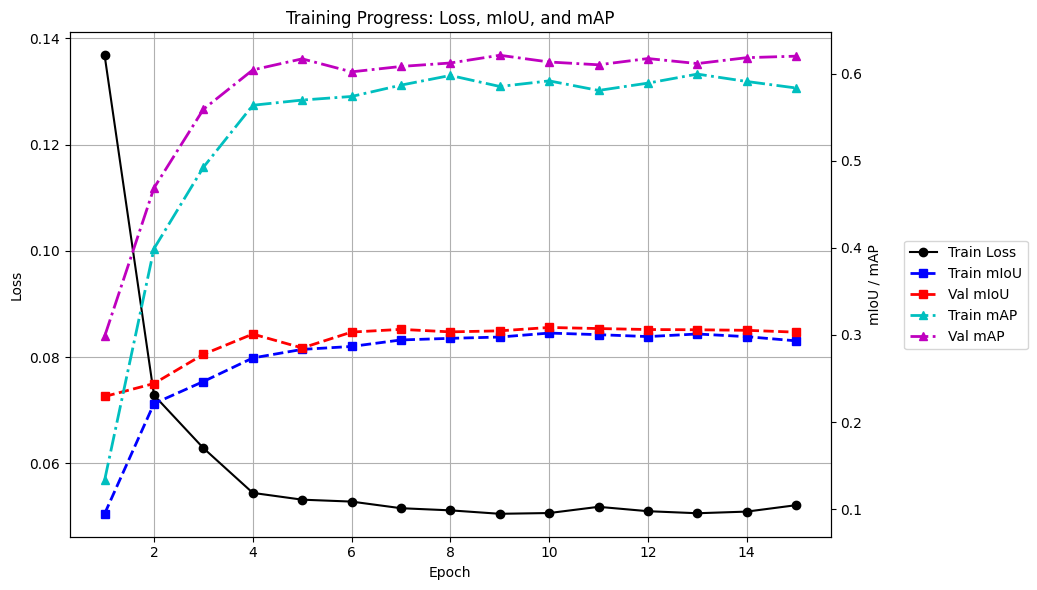

In [22]:
plot_detection_history(history)

In [23]:
# Полученные значения метрик
for k, v in zip(history.keys(), history.values()):
  print(f'{k} : {v[len(v)-1]:.4f}')

train_loss : 0.0521
train_mIoU : 0.2932
val_mIoU : 0.3032
train_mAP : 0.5834
val_mAP : 0.6200


## Функция для подсчета количества людей в магазине

In [25]:
# Итоговый результат работы модели
import matplotlib.patches as patches

def detect_and_visualize(model, image, device, threshold=0.5):
    """
    Функция запускает модель и визуализирует предсказанные bound box.

    Аргументы:
        model: Обученная Fast R-CNN model.
        image: PIL Image или NumPy array.
        device: torch.device ('cuda' or 'cpu').
        threshold: порог для выполнения предсказания.

    Возвращает:
        num_objects: Количество людей на картинке (берутся только те вероятность, у которых больше порога).
    """
    model.eval()

    # Преобразование картинки
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    img_tensor = transform(image).to(device)
    img_tensor = img_tensor.unsqueeze(0)

    with torch.no_grad():
        predictions = model(img_tensor)

    boxes = predictions[0]['boxes']
    labels = predictions[0]['labels']
    scores = predictions[0]['scores']

    # Фильтруем bbox-ы по заданному порогу
    keep = scores >= threshold
    boxes = boxes[keep]
    labels = labels[keep]

    num_objects = len(boxes)

    # Визуализация предсказания
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for box in boxes:
        x1, y1, x2, y2 = box.cpu().numpy()
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

    return num_objects


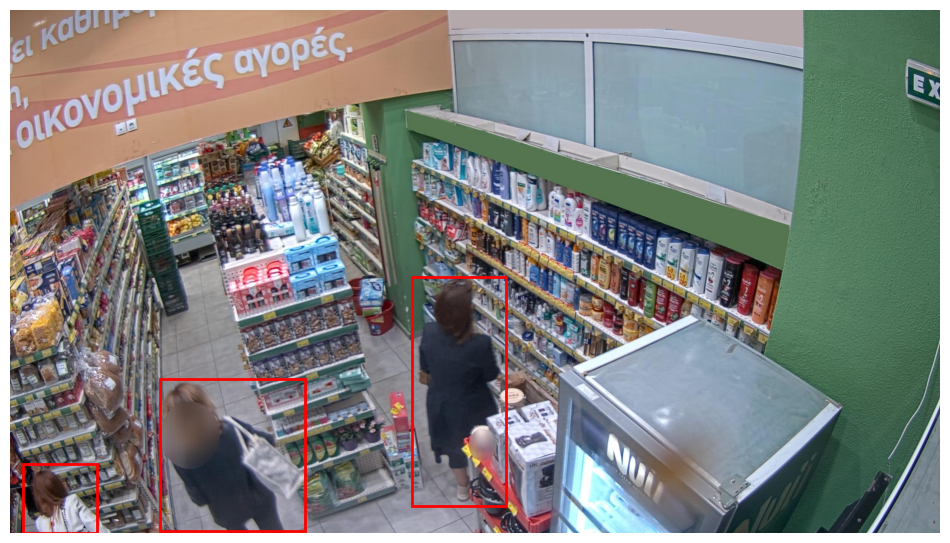

Detected 3 objects


In [28]:
# Пример работы модели
image = Image.open("test_image.jpg").convert("RGB")
num_objects = detect_and_visualize(model, image, device, threshold = 0.5)
print(f"Detected {num_objects} objects")